In [ ]:
#!pip install datasets sentence-transformers scikit-learn

# Task: Text Clustering with Custom KMeans

Using sentence_transformers, convert a set of texts into embeddings, and apply clustering using a custom implementation of KMeans. The goal is to group similar texts based on different distance metrics (such as cosine similarity, Euclidean distance, or Manhattan distance) implemented in the KMeans algorithm.

## 1. Data loading

Load the GO Emotions dataset from Hugging Face to obtain the texts that will be clustered. If you prefer some other dataset you can use it.

In [1]:
from datasets import load_dataset
from jinja2.bccache import bc_version
from torch.xpu import device_of

dataset = load_dataset('google-research-datasets/go_emotions', split='train')
texts = dataset['text']

Print some examples

In [2]:
for i in range(5):
    print(f"Text {i+1}: {dataset[i]['text']}")

Text 1: My favourite food is anything I didn't have to cook myself.
Text 2: Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
Text 3: WHY THE FUCK IS BAYLESS ISOING
Text 4: To make her feel threatened
Text 5: Dirty Southern Wankers


## 2. Convert texts to embeddings

Use the sentence-transformers library to transform the texts into embeddings (numerical vectors) for clustering.

In [6]:
from sentence_transformers import SentenceTransformer
import numpy as np
import torch
from tqdm.auto import tqdm
import pickle

In [7]:
device = 'cuda'
model_checkpoint = 'intfloat/e5-small-v2'
model_name = model_checkpoint.split('/')[1]

In [8]:
#TODO
model = SentenceTransformer(model_checkpoint)

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [9]:
embeddings = []
for text in tqdm(dataset['text']):
    embeddings.append(model.encode(text, normalize_embeddings=True))
embeddings = np.stack(embeddings)

  0%|          | 0/43410 [00:00<?, ?it/s]

C:\Program Files\Python38\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [10]:
with open(f'data/go_emotions_embeddings_{model_name}.pickle', 'wb') as f:
    pickle.dump(embeddings, f)

In [3]:
with open(f'data/go_emotions_embeddings_{model_name}.pickle', 'rb') as f:
    embeddings = pickle.load(f)

In [11]:
print(f"Shape of embeddings: {embeddings.shape}")

Shape of embeddings: (43410, 384)


## 3. Implement custom KMeans

Create a custom implementation of KMeans, supporting at leas four different distance metrics (Correlation, Euclidean, Cosine, Mahalanobis). You shouldn't use any specific libs, only numpy.
Here are the formulas for correlation distance and Mahalanobis distance:

#### Correlation Distance
Correlation distance measures the difference in the direction of vectors rather than their magnitude. The formula for correlation distance is:

$$
d_{\text{corr}}(a, b) = 1 - \frac{\sum_{i=1}^{n}(a_i - \bar{a})(b_i - \bar{b})}{\sqrt{\sum_{i=1}^{n}(a_i - \bar{a})^2} \sqrt{\sum_{i=1}^{n}(b_i - \bar{b})^2}}
$$

where:
- $a$ and $b$ are two vectors,
- $\bar{a}$ and $\bar{b}$ are the mean values of the components of vectors $a$ and $b$, respectively.

or using ```np.corrcoef```:

$$
d_{\text{corr}}(a, b) = 1 - np.corrcoef(a, b)[0,1]
$$


#### Mahalanobis Distance
Mahalanobis distance accounts for not only the distance between points but also the covariance between them. The formula is:

$$
d_{\text{mahal}}(a, b) = \sqrt{(a - b)^T S^{-1} (a - b)}
$$

where:
- $a$ and $b$ are two vectors,
- $S$ is the covariance matrix of the features,
- $S^{-1}$ is the inverse covariance matrix.


In [12]:
def euclidean_distance(a, b):
    #TODO
    result = torch.sqrt(torch.sum((a - b) ** 2))
    return result

def cosine_distance(a, b):
    #TODO
    result = 1 - (a @ b) / (torch.sqrt(torch.sum(a ** 2)) * torch.sqrt(torch.sum(b ** 2)))
    return result

def mahalanobis_distance(a, b, SI):
    #TODO
    result = torch.sqrt(((a - b).T @ SI) @ (a - b))
    return result

def correlation_distance(a, b):
    #TODO
    a_mean = a.mean()
    b_mean = b.mean()
    numerator = torch.sum((a - a_mean) * (b - b_mean))
    denominator = torch.sqrt(torch.sum((a - a_mean) ** 2)) * torch.sqrt(torch.sum((b - b_mean) ** 2))
    if denominator == 0:
        result = 1
    else:
        result = 1 - numerator / denominator
    return result

Implement custom K-Means class

In [14]:
class CustomKMeans:
    def __init__(self, n_clusters=3, max_iter=100, distance_metric='euclidean', device='cuda', **kwargs):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.distance_metric = distance_metric
        self.device = device if torch.cuda.is_available() else 'cpu'
        self.centroids = None
        self.labels_ = None
        self.kwargs = kwargs

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32).to(self.device)

        random_indices = torch.randperm(len(X))[:self.n_clusters]
        self.centroids = X[random_indices].clone()

        for _ in tqdm(range(self.max_iter)):
            self.labels_ = torch.tensor([self._assign_label(x) for x in X], device=self.device)

            new_centroids = torch.stack([X[self.labels_ == i].mean(dim=0) if torch.sum(self.labels_ == i) > 0 else self.centroids[i]
                                         for i in range(self.n_clusters)])

            if torch.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids

        self.labels_ = self.labels_.cpu().numpy()

    def _assign_label(self, x):
        if self.distance_metric == 'euclidean':
            compute_distance = euclidean_distance
        elif self.distance_metric == 'cosine':
            compute_distance = cosine_distance
        elif self.distance_metric == 'mahalanobis':
            compute_distance = lambda a, b: mahalanobis_distance(a, b, **self.kwargs)
        elif self.distance_metric == 'correlation':
            compute_distance = correlation_distance
        else:
            raise NotImplementedError("Unknown distance metric")

        distances = torch.stack([compute_distance(x, centroid) for centroid in self.centroids])

        return torch.argmin(distances).item()

## 4. Fit the custom K-Means

Fit the custom KMeans model to the dataset using all of the distance metrics and obtain cluster labels.

In [15]:
n_clusters = 10
cov_matrix = np.cov(embeddings, rowvar=False)
inv_cov_matrix = torch.Tensor(np.linalg.inv(cov_matrix)).to(device)

In [16]:
metrics = ['euclidean', 'cosine', 'correlation', 'mahalanobis']

In [30]:
labels = {}

for metric in metrics:
    custom_kmeans = CustomKMeans(n_clusters=10, max_iter=5, distance_metric=metric, SI=inv_cov_matrix)
    custom_kmeans.fit(embeddings)
    labels[metric] = custom_kmeans.labels_

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-12-0ae80c245587>:13: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3701.)
  result = torch.sqrt(((a - b).T @ SI) @ (a - b))


In [28]:
print("Custom KMeans labels for the first 10 texts:")
print(labels[:10])

Custom KMeans labels for the first 10 texts:
tensor([8, 2, 2, 6, 3, 2, 0, 5, 1, 7], device='cuda:0')


## 5. Visualize the results

Visualize the clusters by reducing the dimensionality of the embeddings using PCA and plotting the clusters in 2D space.  
You should get something like this:

<a href="https://ibb.co/nRY9hQf"><img src="https://i.ibb.co/zNBpKPb/output.png" alt="output" border="0"></a>

In [18]:
from sklearn.decomposition import PCA
import seaborn as sns

In [19]:
#TODO
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

In [23]:
labels = custom_kmeans.labels_.cpu().numpy()

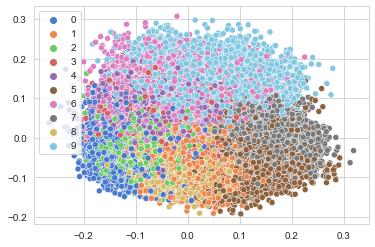

In [32]:
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=labels['euclidean'], palette='muted');

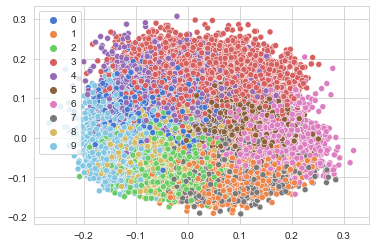

In [33]:
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=labels['cosine'], palette='muted');

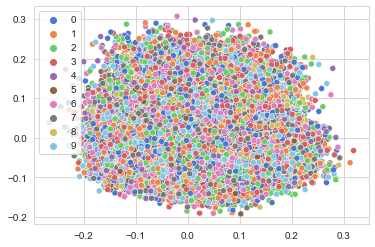

In [34]:
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=labels['mahalanobis'], palette='muted');

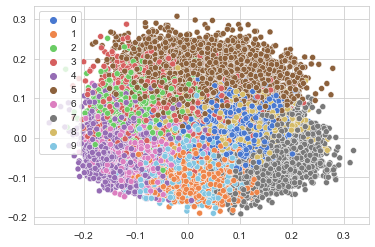

In [35]:
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=labels['correlation'], palette='muted');

Let's print examples of the text for each cluster

In [55]:
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == cluster]
    for text in cluster_texts[:5]:
        print(f"- {text}")


Cluster 0:
- Hello everyone. Im from Toronto as well. Can call and visit in personal if needed.
- Thank you friend
- Super, thanks
- Happy to be able to help.
- aw, thanks! I appreciate that! 

Cluster 1:
- To make her feel threatened
- Dirty Southern Wankers
- Fucking coward.
- that is what retardation looks like
- Slowing things down now

Cluster 2:
- Damn youtube and outrage drama is super lucrative for reddit
- Demographics? I don’t know anybody under 35 who has cable tv.
- A new study just came out from China that it's actually too late.
- What does FPTP have to do with the referendum?
- The republicans are the military. You are an idiot.

Cluster 3:
- My favourite food is anything I didn't have to cook myself.
- It might be linked to the trust factor of your friend.
- R/sleeptrain Might be time for some sleep training. Take a look and try to feel out what's right for your family.
- i got a bump and a bald spot. i feel dumb <3
- When I feel down I listen to music.

Cluster 4:
- W

## 6. Report

Make a conclusion and write a short report. What are the differences between the methods used? What are their limitations? What is the applicability of each?

Due to the time limit, we had to decrease max_iter to 5. Among the metrics, only Euclidean and correlation managed to converge to meaningful clusters. The other ones did not fare well. Some of the clusters can be interpreted: friendly texts or texts with question marks.

The metrics are distributed by increasing runtime as following: Euclidean, cosine, Mahalanobis, correlation. It imposes difficulties to applicability in some cases.